# Results: Manual vs Automated Feature Engineering

In this notebook, we will compare the manual, semi-automated, and fully automated (featuretools) feature engineering approaches for the Kaggle Home Credit Default Risk competition. For comparison we will focus on time: how long it took to make the features, and performance: the score in cross validation and when submitted to the Kaggle leaderboard.

The summary of results are as follows:

| Method                    	| Total Features                      	| Time Spent (conservative estimate)  	| CV ROC AUC default model 	| Public Leaderboard  ROC AUC default model 	| CV ROC AUC  Optimized Model 	| Public Leaderboard ROC AUC optimized model 	|
|-----------------------------	|-------------------------------------	|-------------------------------------	|--------------------------	|-------------------------------------------	|-----------------------------	|--------------------------------------------	|
| Main after one-hot encoding 	| 241                                 	| 15 minutes                          	| 0.75565                  	| 0.741                                     	|                             	|                                            	|
| Manual Feature Engineering  	| 271 (30 from  manual engineering)   	| 7.5 hours (15 minutes per feature)  	| 0.77227                  	| 0.776                                     	| 0.78052                     	|                                            	|
| Manual + Semi-Automated     	| 1444 (1173 from  semi-auto methods) 	| 10 hours (0.5 minutes per feature)  	| 0.77987                  	| 0.782                                     	|                             	|                                            	|
| Fully Automated             	| 2800 (2559 from  featuretools)      	| 2 hours (0.05 minutes per  feature) 	|                          	|                                           	|                             	|                                            	|

## Explanation of Result Categories

* __Method__: refers to the method used to construct the set of features. The baseline set is the main dataframe (`app`) after one-hot encoding categorical variables
* __Total Features__: the total number of predictor variables after implementing the method. Numbers in parenthesis indicate the features built by the method alone since each method built on the previous
* __Time Spent__: Total time spent creating the set of features. This is a __conservative__ estimate as it does not include the hundreds of hours spent by other data scientists working on the problem or the hours I personally spent reading about the problem. This refers only to the time I spent actively coding the technique.
* __CV ROC AUC default model__. The 5-fold cross validation ROC AUC using the default hyperparameter values of the Gradient Boosting Machine (GBM) implemented with the LightGBM library. The number of estimators was found using 100 rounds of early stopping with the 5-fold cv.
* __Public Leaderboard ROC AUC default model__. The ROC AUC score of dataset from the GBM model when submitted to the public leaderboard on Kaggle. The GBM model used the same default hyperparameters and the cv early stopping results for the number of estimators. Predictions were made on the testing data and then uploaded to Kaggle where the Public Leaderboard is calculated using 10% of the total testing observations. The final leaderboard will be made known at the end of the competition. 
* __CV ROC AUC optimized model__. The 5-fold cross validation ROC AUC using the best hyperparameters from random search for 150 iterations. 
* __Public Leaderboard ROC AUC optimized model__. The ROC AUC score when submitted to the Kaggle competition using the hyperparameters from random search

## Random Search

After using the default hyperparameters of the GBM in LightGBM as a first approximation of the dataset performance, random search was run for 150 iterations on the manual feature engineering dataset (saved as `features_manual_domain.csv`). These results are available in `random_search_domain.csv`. Below, we go through the results of random search and then use the best hyperparameter values to assess cross validation ROC AUC. 

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# modeling
import lightgbm as lgb

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

from utils import format_data, cross_validate_and_submit, plot_feature_importances

%matplotlib inline

RSEED = 50

In [2]:
random = pd.read_csv('../input/results/random_search_domain.csv', index_col=0)

# Sort with best values on top
random = random.sort_values('score', ascending = False).reset_index(drop = True)
random.head(10)

,score,hyperparameters,iteration,time
0,0.780678,"{'verbose': 1, 'is_unbalance': True, 'boosting...",125,384.011306
1,0.780417,"{'verbose': 1, 'is_unbalance': True, 'boosting...",109,370.445021
2,0.780216,"{'verbose': 1, 'is_unbalance': True, 'boosting...",9,137.456086
3,0.780154,"{'verbose': 1, 'is_unbalance': True, 'boosting...",41,134.778583
4,0.780134,"{'verbose': 1, 'is_unbalance': True, 'boosting...",97,169.808482
5,0.780001,"{'verbose': 1, 'is_unbalance': True, 'boosting...",7,365.550064
6,0.779729,"{'verbose': 1, 'is_unbalance': True, 'boosting...",62,122.443247
7,0.779705,"{'verbose': 1, 'is_unbalance': False, 'boostin...",135,143.399460
8,0.779693,"{'verbose': 1, 'is_unbalance': False, 'boostin...",126,136.182787
9,0.779674,"{'verbose': 1, 'is_unbalance': True, 'boosting...",75,244.119122


As a reminder, the best cross validation ROC AUC before random search was 0.77227. The random search significantly improved the cross validation score. 

We can look at the best hyperparameter values and then use these to train a model for any dataset.

In [3]:
import ast
import pprint

best_hyp = ast.literal_eval(random.loc[0, 'hyperparameters'])
del best_hyp['n_estimators'], best_hyp['verbose'], best_hyp['metric']

pprint.pprint(best_hyp)

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.6,
 'is_unbalance': True,
 'learning_rate': 0.005284379855924019,
 'min_child_samples': 470,
 'num_leaves': 100,
 'reg_alpha': 0.836734693877551,
 'reg_lambda': 0.7755102040816326,
 'subsample': 0.8888888888888888,
 'subsample_for_bin': 260000}


Now we will make a model from these hyperparameters and assess the  5-fold CV.

# Manual Results

In [4]:
manual_features = pd.read_csv('../input/features_manual_domain.csv')
manual_cv_results, manual_fi, manual_submission = cross_validate_and_submit(manual_features, best_hyp)

5-Fold CV ROC AUC: 0.78052 with std: 0.00431.


### Manual Feature Importances

,feature,importance,importance_normalized,cumulative_importance
0,LOAN_RATE,11706,0.049043,0.049043
1,EXT_SOURCE_3,7163,0.030010,0.079053
2,PREVIOUS_LOAN_DIFFERENCE_MEAN,7025,0.029432,0.108484
3,DAYS_BIRTH,6835,0.028636,0.137120
4,PREVIOUS_LOAN_RATE_MEAN,6551,0.027446,0.164566
5,CASH_AVERAGE_LOAN_LENGTH,6390,0.026771,0.191337
6,PREVIOUS_OTHER_LOAN_SUM,6336,0.026545,0.217882
7,EXT_SOURCE_2,6227,0.026088,0.243970
8,EXT_SOURCE_MEAN,5957,0.024957,0.268927
9,AMT_ANNUITY,5629,0.023583,0.292510


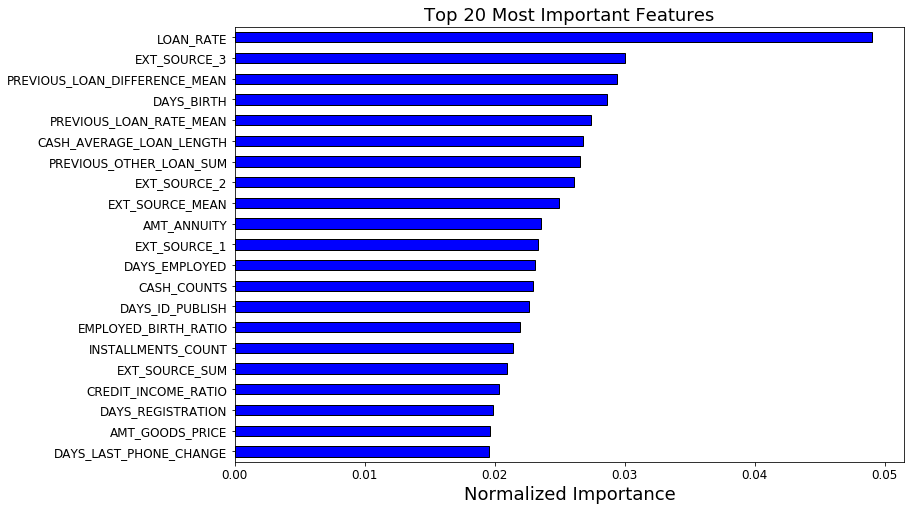

In [5]:
norm_manual_fi = plot_feature_importances(manual_fi, 20)
norm_manual_fi.head(20)

# Fully Automated Results

In [ ]:
# Need to reset index because SK_ID_CURR is currently the index
auto_features = pd.read_csv('../input/feature_matrix.csv', low_memory=False).reset_index()

for col in ['SUM(bureau.PREVIOUS_OTHER_LOAN_RATE)', 'SUM(bureau.PREVIOUS_OTHER_LOAN_RATE WHERE CREDIT_ACTIVE = Closed)',
            'SUM(bureau.PREVIOUS_OTHER_LOAN_RATE WHERE CREDIT_ACTIVE = Active)', 'SUM(bureau_balance.bureau.PREVIOUS_OTHER_LOAN_RATE)']:
    auto_features[col] = auto_features[col].astype(np.float32)
    
print(auto_features.shape)
# auto_cv_results, auto_fi, auto_submission = cross_validate_and_submit(auto_features, best_hyp)

In [ ]:
import sys
print(sys.getsizeof(auto_features) / 1e9)
import psutil 

psutil.virtual_memory().total / 1e9 

In [ ]:
auto_features.columns[np.where(auto_features.dtypes == 'O')[0]]

In [ ]:
cat = pd.get_dummies(auto_features.select_dtypes('object'))
cat.shape

In [ ]:
set(auto_features.dtypes)

In [ ]:
auto_features = auto_features.select_dtypes(['number', 'bool'])
auto_features.shape

In [ ]:
auto_features = pd.concat([auto_features, cat], axis = 1)
auto_features.shape

In [ ]:
set(auto_features.dtypes)

In [ ]:
%load_ext autoreload 
%autoreload 2

In [ ]:
cv_results, fi, submission = cross_validate_and_submit(auto_features, best_hyp, free_memory = True)

In [ ]:
psutil.virtual_memory()

### Fully Automated Feature Importances

In [ ]:
norm_auto_fi = plot_feature_importances(auto_fi, 20)
norm_auto_fi.head(20)

In [ ]:
auto_submission.to_csv('../input/submission_auto.csv', index = False)

# Semi-Automated Results

In [ ]:
semi_features = pd.read_csv('../input/features_semi.csv')
semi_cv_results, semi_fi, semi_submission = cross_validate_and_submit(semi_features, best_hyp)

### Semi-Automated Feature Importances

In [ ]:
norm_semi_fi = plot_feature_importances(semi_fi)
norm_semi_fi.head(20)

# Conclusions

Overall the results show that feature engineering is very important.